# Telco Customer Churn Prediction - Model Comparison and Tuning

This notebook compares multiple classification models on the churn dataset.  
We will evaluate performance using accuracy, recall, F1-score, and ROC AUC.  
The best-performing model will be tuned using GridSearchCV and finalized with cross-validation.


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

In [15]:
df_encoded = pd.read_csv("../data/preprocessed_telco.csv")

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
models = {
    "Logistic Regression (Balanced)": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}


In [23]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })


comparison_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df


,Model,Accuracy,Recall,F1-score,ROC AUC
0,Logistic Regression (Balanced),0.747690,0.748663,0.612022,0.833983
1,XGBoost,0.778252,0.548128,0.567867,0.819670
2,Random Forest,0.795309,0.467914,0.548589,0.825767


## Hyperparameter Tuning for Logistic Regression (GridSearchCV)


In [26]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}


grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='f1', verbose=1)

In [28]:
print("Best Parameters:", grid.best_params_)
print("Best F1-score (CV):", grid.best_score_)


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1-score (CV): 0.6355920810100724


In [30]:
best_model = grid.best_estimator_
y_test_pred_grid = best_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Test Accuracy:", accuracy_score(y_test, y_test_pred_grid))
print(classification_report(y_test, y_test_pred_grid))


Test Accuracy: 0.7476901208244492
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.75      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



In [32]:
import joblib
joblib.dump(best_model, "../models/final_logistic_model.joblib")


['../models/final_logistic_model.joblib']

## Hyperparameter Tuning for XGBoost using GridSearchCV
In this section, we perform hyperparameter tuning for the XGBoost classification model using GridSearchCV. Various combinations of parameters will be tested using 5-fold cross-validation. The goal is to find the parameter set that maximizes the F1-score, particularly for the positive (churned) class. This process aims to improve the model's generalization ability and maintain a better balance between precision and recall.

In [ ]:
from xgboost import XGBClassifier


 
xgb = XGBClassifier(random_state=42,  eval_metric='logloss')

 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

 
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

 
grid_xgb.fit(X_train, y_train)


### Best Parameters from GridSearchCV (XGBoost)

After running GridSearchCV on the XGBoost model, we extract the best combination of hyperparameters based on cross-validated F1-score.


In [43]:
print("Best Parameters:", grid_xgb.best_params_)
print("Best F1-score (CV):", grid_xgb.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best F1-score (CV): 0.5863894070622923


### Evaluation of the Tuned XGBoost Model on the Test Set

We now evaluate the best XGBoost model using the test set. This includes accuracy, recall, precision, and F1-score for both classes.


In [46]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Test Accuracy: 0.7910447761194029
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



###  ROC Curve and AUC Score (XGBoost)

We visualize the ROC curve and calculate the AUC score to evaluate the model's ability to distinguish between classes.


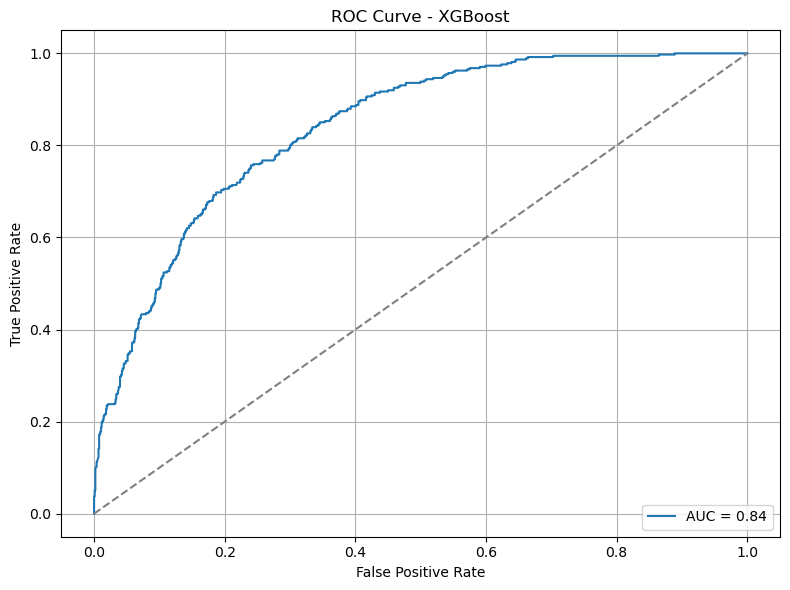

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve


 
y_scores_xgb = best_xgb.predict_proba(X_test)[:, 1]

 
fpr, tpr, _ = roc_curve(y_test, y_scores_xgb)
auc_score = roc_auc_score(y_test, y_scores_xgb)

 
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../images/roc_curve_xgb.png", dpi=300)
plt.show()


### Confusion Matrix (XGBoost)

The confusion matrix gives insight into true/false positives and negatives.


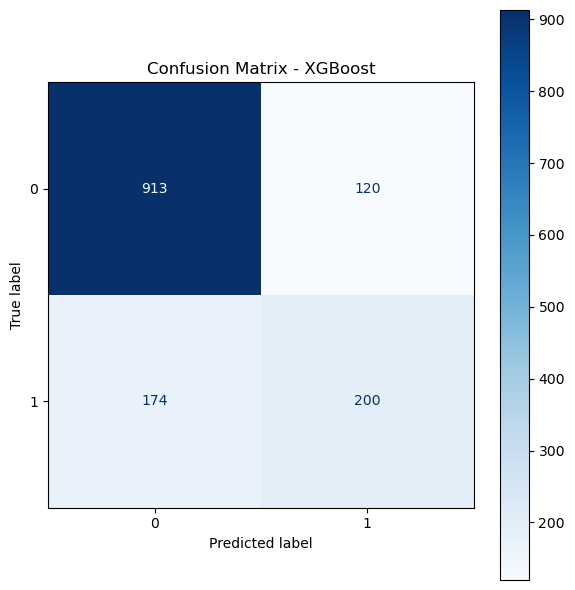

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.savefig("../images/confusion_matrix_xgb.png", dpi=300)
plt.show()


### Save the Final Tuned XGBoost Model

We save the best-performing XGBoost model as a `.joblib` file for future use or deployment.


In [65]:
import joblib
joblib.dump(best_xgb, "../models/final_xgb_model.joblib")


['../models/final_xgb_model.joblib']

## Model Comparison and Final Model Selection

In this section, we compared two models: Logistic Regression (with class balancing) and XGBoost (after hyperparameter tuning). Below is a summary of their performance on the test dataset:

| Model                  | Accuracy | Recall | F1-Score | ROC AUC |
|------------------------|----------|--------|----------|---------|
| Logistic Regression    | 0.7477   | 0.7486 | 0.6120   | 0.8339  |
| XGBoost (tuned)        | 0.7910   | 0.5310 | 0.5800   | 0.8400  |

- **Logistic Regression** performed well in terms of recall, particularly for detecting churned customers, making it a solid baseline.
- **XGBoost**, while showing slightly lower recall, achieved **higher accuracy and ROC AUC**, indicating a stronger ability to distinguish between classes overall.

 **Final Decision:**  
We selected **XGBoost** as our final model due to its superior overall performance and robustness after hyperparameter tuning. It achieved the highest AUC (0.84), which is critical for imbalanced classification tasks like churn prediction.

The final model was saved using `joblib` for future use in deployment or inference.



## Predicting with Final Model

Below is an example of how to load the saved model and make predictions on new customer data.


In [90]:
import pandas as pd
 
feature_names = list(X_train.columns)

 
sample_df = pd.DataFrame(columns=feature_names)

 
sample_df = X_train.iloc[[0]]   

 
model = joblib.load("../models/final_xgb_model.joblib")

 
prediction = model.predict(sample_df)
print("Prediction:", prediction)


Prediction: [0]


##  Conclusion

This project aimed to predict customer churn using the Telco Customer Churn dataset by applying a complete machine learning workflow. The process involved data cleaning, feature engineering, normalization, class balancing, model training, hyperparameter tuning, evaluation, and model saving.

### Key Steps:
- **Preprocessing:** Converted categorical variables using `get_dummies()`, handled missing values, and normalized continuous features.
- **Class Imbalance Handling:** Applied class weights to improve model fairness between churned and non-churned customers.
- **Model Training & Tuning:** Trained both Logistic Regression and XGBoost classifiers. Performed `GridSearchCV` to find the best hyperparameters.
- **Model Evaluation:** Evaluated models using accuracy, F1-score, recall, ROC AUC, and confusion matrix.
- **Final Model:** Chose XGBoost as the final model due to its superior AUC score (0.84). Saved the model using `joblib` for reuse.
- **Prediction:** Demonstrated how to load the saved model and predict churn on new customer data.

This notebook is structured to reflect real-world machine learning practices.

